## Import libraries

In [2]:
# !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.6 MB/s eta 0:00:00


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import pickle as pk

## Load the data

In [4]:
houses_df = pd.read_csv('/content/housing.csv')

## Data Inspection

In [5]:
houses_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
houses_df.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1476,-122.04,37.96,16.0,2913.0,723.0,1705.0,693.0,2.9097,106300.0,NEAR BAY
2663,-123.75,40.11,35.0,2052.0,477.0,900.0,402.0,1.9625,101500.0,<1H OCEAN
20239,-119.28,34.27,44.0,706.0,176.0,399.0,149.0,3.0089,166700.0,NEAR OCEAN
12294,-116.93,33.93,13.0,7804.0,1594.0,3297.0,1469.0,2.0549,95600.0,INLAND
16908,-122.37,37.58,34.0,2697.0,313.0,810.0,279.0,12.4291,500001.0,NEAR OCEAN


In [7]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Check data quality

In [8]:
houses_df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [9]:
houses_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


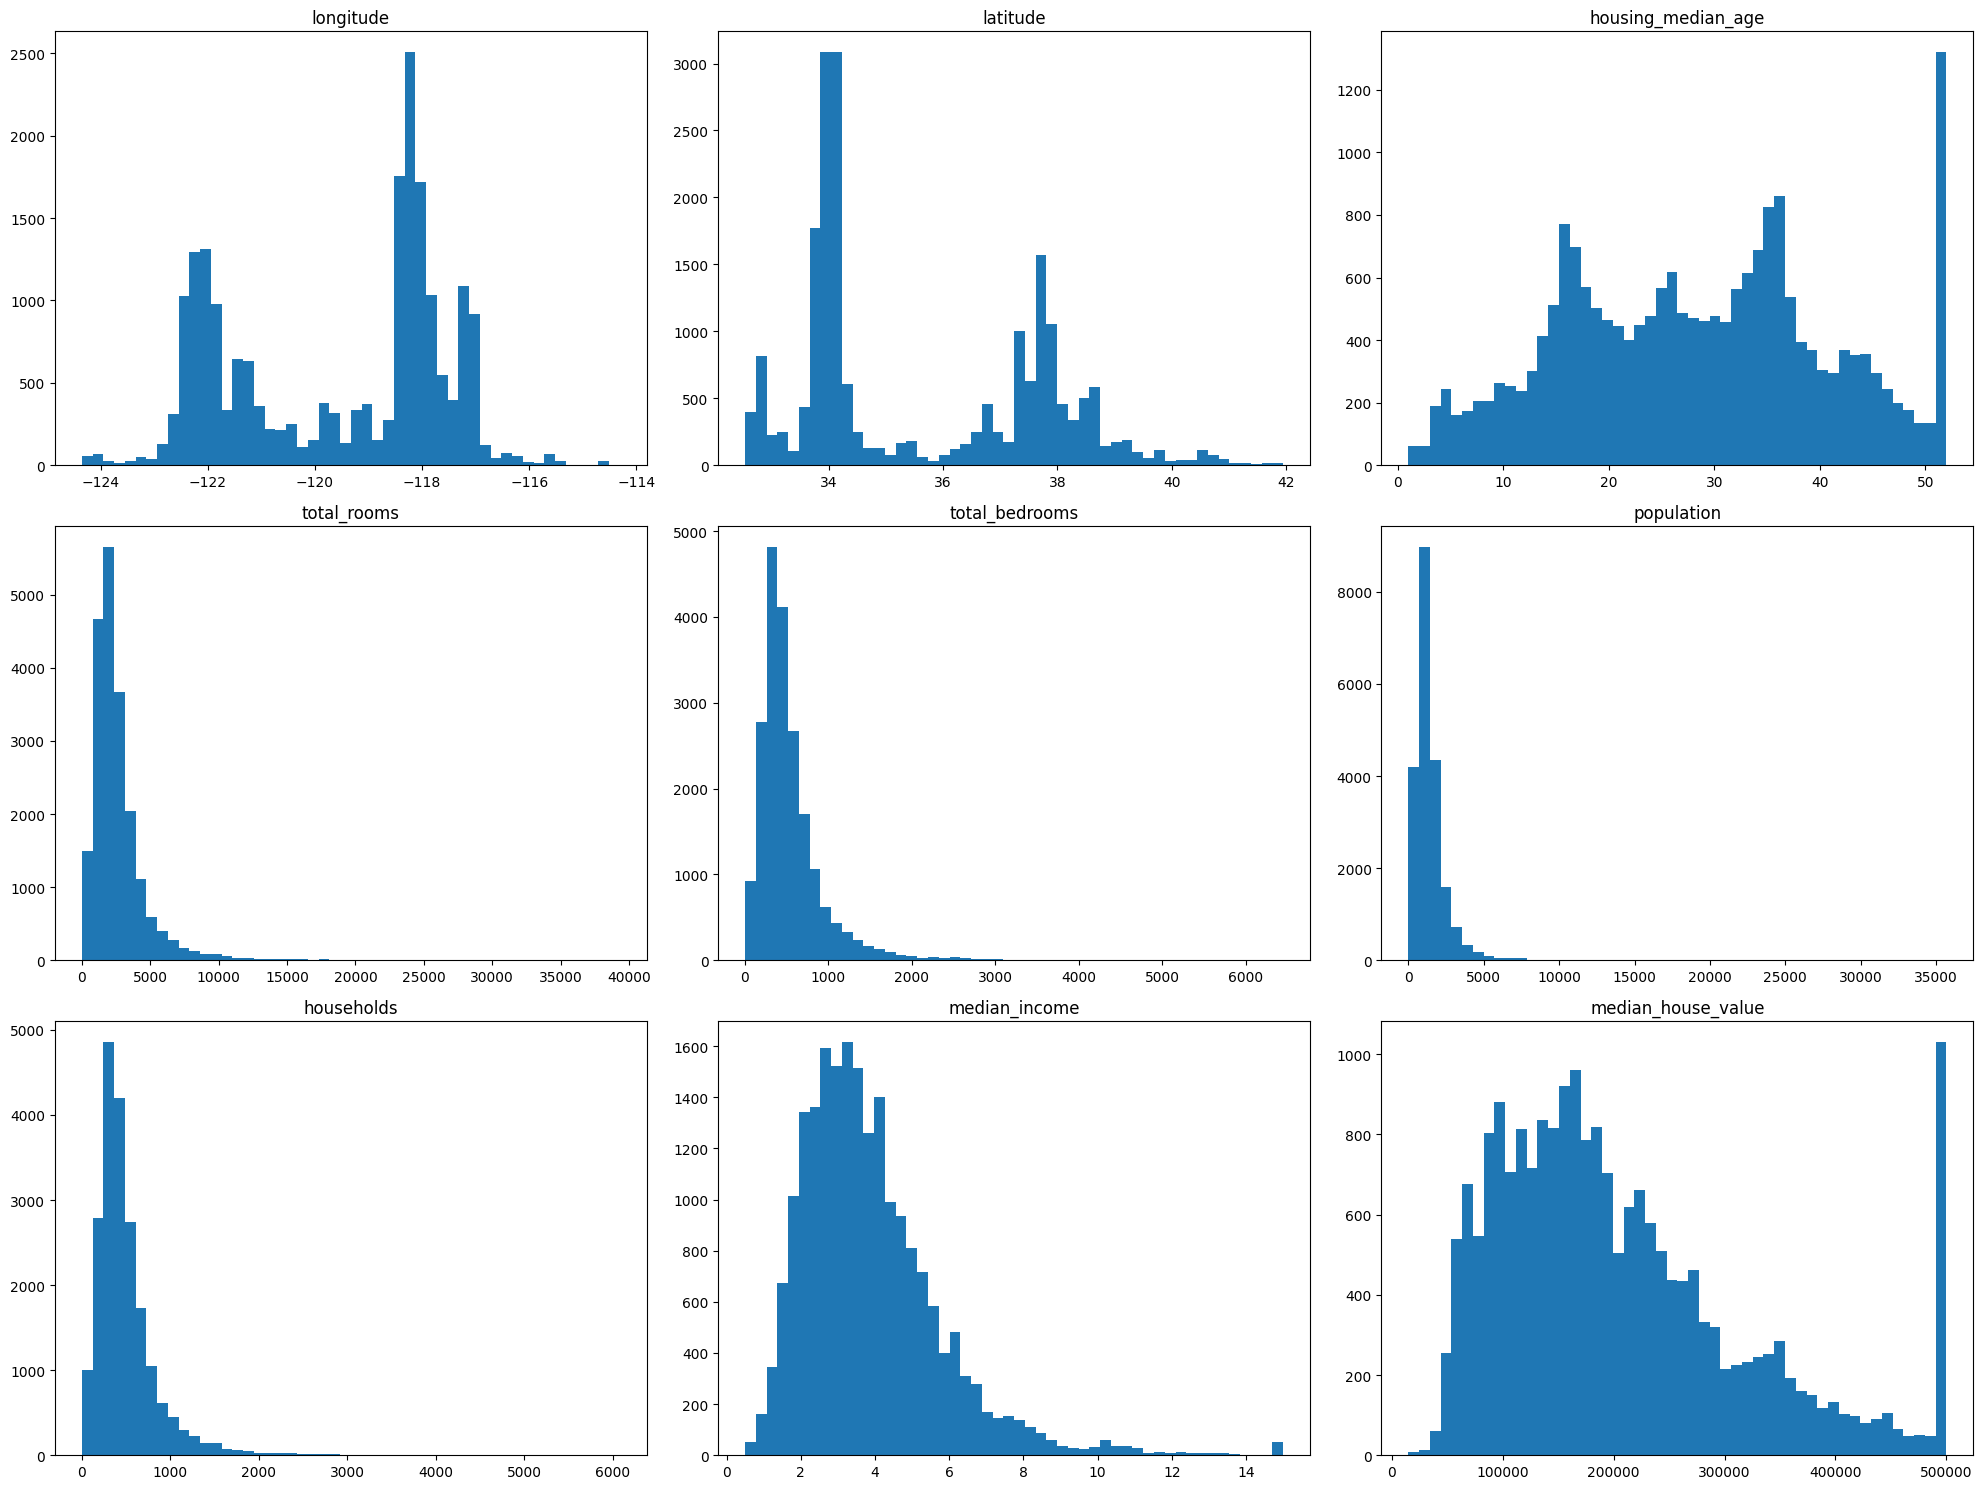

In [10]:
houses_df.hist(figsize=(20,15), bins=50, grid=False)
plt.tight_layout()
plt.show();

**As i see the column total_bedrooms that have missing values from the histogram plot is a left skewed<br>**
**So the mean is greater the median so when filling the missing should fill with mean not with median**

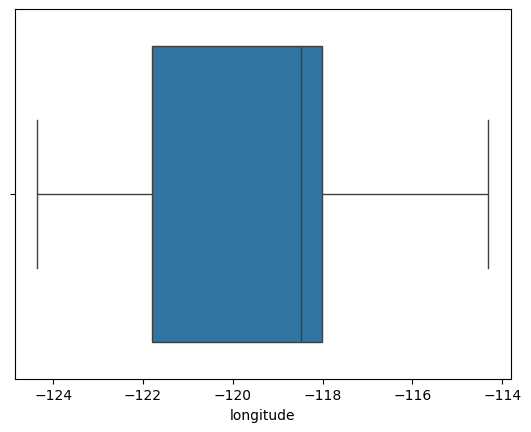

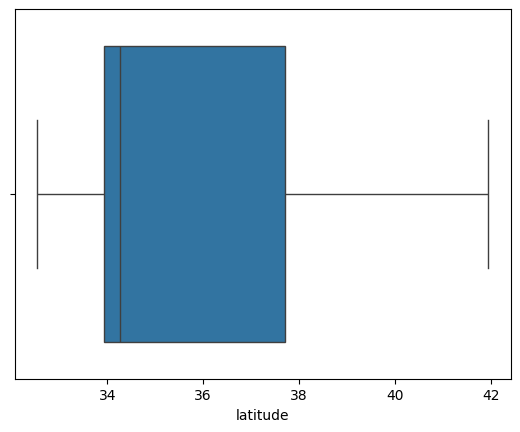

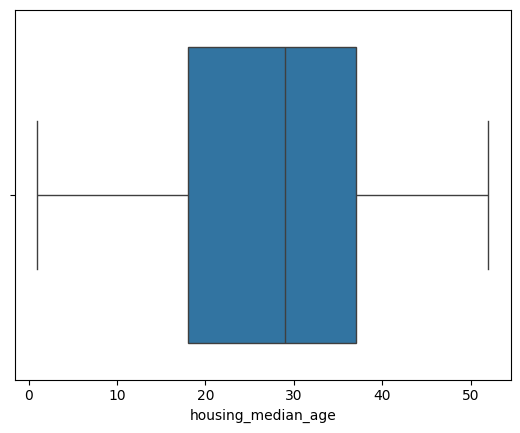

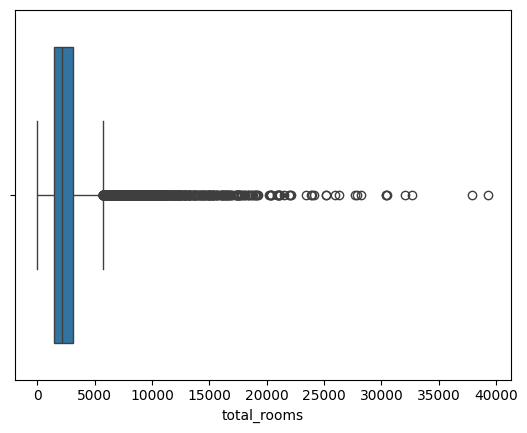

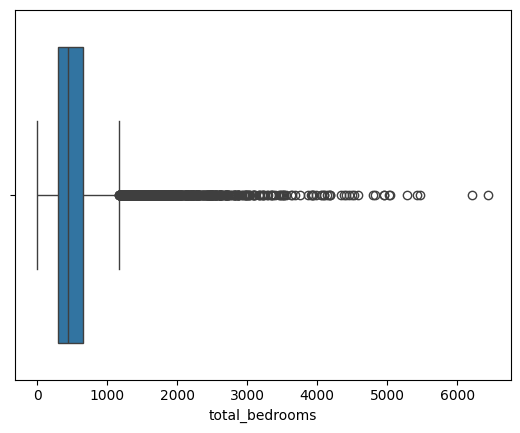

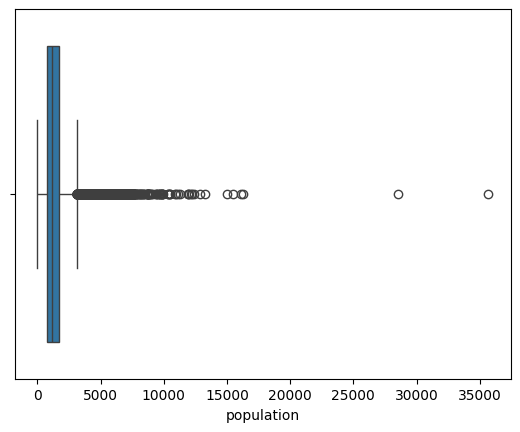

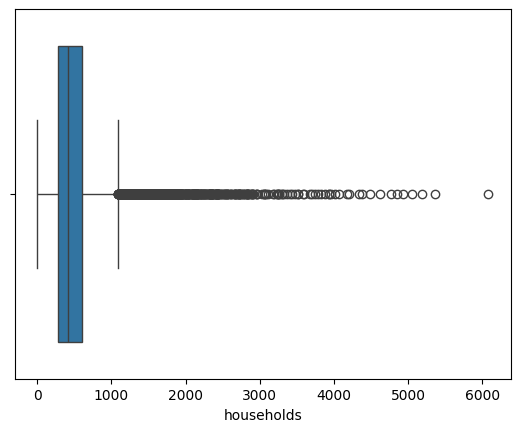

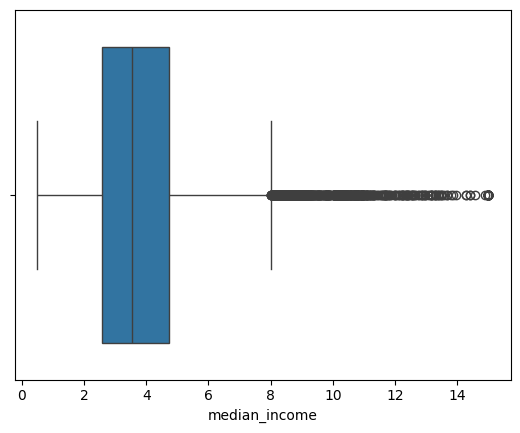

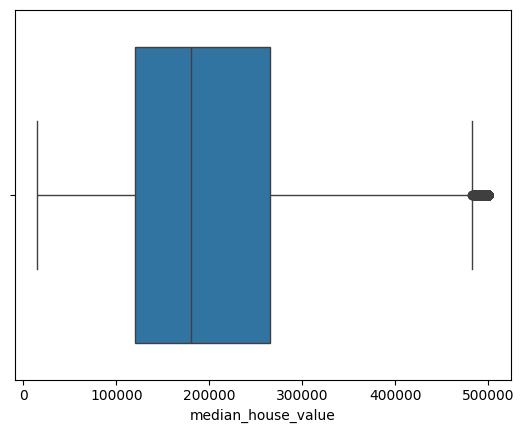

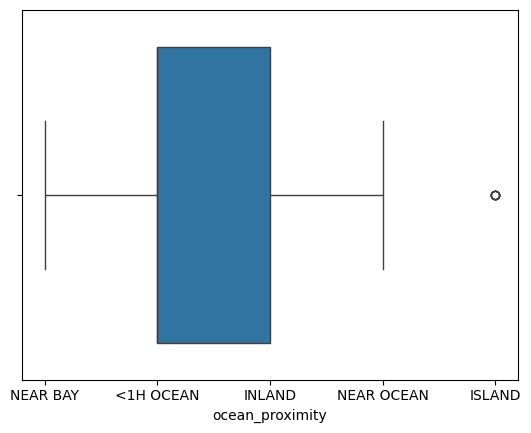

In [11]:
for col in houses_df.columns:
  sns.boxplot(x=houses_df[col])
  plt.show()

## Data Preporcessing

In [53]:
def wrangle(df):
  # Handle Missing values
  df["total_bedrooms"] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())

  # Handle Outliers
  df = df[df['total_bedrooms'] < 4100]
  df = df[df['median_income'] < 15]
  df = df[df['population'] < 35001]
  df = df[df['households'] < 4001]

  # Encode categorical features
  df = pd.get_dummies(df, columns=["ocean_proximity"], dtype=float)

  # Handle data leakage
  df = df.drop(columns=["longitude", "latitude"])

  return df

In [54]:
wrangled_df = wrangle(houses_df)

In [55]:
wrangled_df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


In [56]:
wrangled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20567 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   housing_median_age          20567 non-null  float64
 1   total_rooms                 20567 non-null  float64
 2   total_bedrooms              20567 non-null  float64
 3   population                  20567 non-null  float64
 4   households                  20567 non-null  float64
 5   median_income               20567 non-null  float64
 6   median_house_value          20567 non-null  float64
 7   ocean_proximity_<1H OCEAN   20567 non-null  float64
 8   ocean_proximity_INLAND      20567 non-null  float64
 9   ocean_proximity_ISLAND      20567 non-null  float64
 10  ocean_proximity_NEAR BAY    20567 non-null  float64
 11  ocean_proximity_NEAR OCEAN  20567 non-null  float64
dtypes: float64(12)
memory usage: 2.0 MB


## Split data

In [57]:
X = wrangled_df.drop(columns=["median_house_value"])
y = wrangled_df["median_house_value"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16453, 11)
(4114, 11)
(16453,)
(4114,)


## Scale the features

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Use a baseline model to compare with

In [49]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [75]:
y_pred = lr_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
print(f"Train accuarcy {lr_model.score(X_train_scaled, y_train)}")

R-squared: 0.6388938522908197
Train accuarcy 0.6396152211002186


## Use `RandomForest` model

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [74]:
y_pred = rf_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

print("R-squared:", r2)
print(f"Train accuarcy {rf_model.score(X_train_scaled, y_train)}")

R-squared: 0.7186540941587815
Train accuarcy 0.9603721691872297


## Hyperparamter Tuning

In [67]:
# hyperparameter tuning for randomforest model
param = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 25],
}

In [68]:
# It takes some time to run
cv = GridSearchCV(rf_model, param_grid=param, cv=5, n_jobs=-1, verbose=1)
cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 25],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [69]:
# Save the best parameters
best_params = cv.best_params_
print(best_params)

{'max_depth': 25, 'n_estimators': 200}


In [70]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=25)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=25, n_estimators=200, random_state=42)

In [73]:
y_pred = rf_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

print("R-squared:", r2)
print(f"Train accuarcy {rf_model.score(X_train_scaled, y_train)}")

R-squared: 0.7186540941587815
Train accuarcy 0.9603721691872297


## Save the best model

In [77]:
with open("best_model", "wb") as f:
  pk.dump(rf_model, f)

## Ahmed Yusri